In [1]:
! pip3 install -U scikit-learn scipy matplotlib
! pip3 install -U shap 
! pip3 install -U lime 
! pip3 install -U xgboost 
! pip3 install -U eli5 
! pip3 install -U seaborn 

! pip3 install ipywidgets

! pip3 install lightgbm

! pip3 install mlxtend

Requirement already up-to-date: scikit-learn in /home/ava/.local/lib/python3.8/site-packages (0.24.1)
Requirement already up-to-date: scipy in /home/ava/.local/lib/python3.8/site-packages (1.6.0)
Requirement already up-to-date: matplotlib in /home/ava/.local/lib/python3.8/site-packages (3.3.4)
     |████████████████████████████████| 352 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 16.1 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 25.3 MB 10.6 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.38.1-cp38-cp38-linux_x86_64.whl size=537090 sha256=4dc9832e438ccde2eb354333c60a454ae1c8c88c5670c96ed9510a58b274555c
  Stored in directory: /home/ava/.cache/pip/wheels/87/7c/3f/1012132e5a8db6b4e125e64be0fd96f581803e101b0403c65f
Successfully built shap
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |███████████████

In [2]:
import os

import numpy as np 
import pandas as pd 

import pickle

import itertools 

from eli5 import show_prediction, show_weights
from eli5.sklearn import PermutationImportance

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb 
import lightgbm as lgb

import seaborn as sns 

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt 

from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier

import sys
sys.path.append('..')

from inxai import *
import shap
import lime

In [3]:
path = '../examples/'

def to_pickle(obj, name):
    with open(path + name + '.pickle', 'wb') as f:
        pickle.dump(obj, f)

def from_pickle(name):
    return pd.read_pickle(path + name + '.pickle')


In [4]:
def approximateAreaUnderTheCurveAccLoss(acc_loss): 
    acc_los_abs = [0 if value < 0 else value for value in acc_loss]
    return sum(acc_los_abs) / len(acc_los_abs)


In [5]:
df = pd.read_csv("../examples/data/compass/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")
print(df.shape)
display(df.columns)
df.head()

(6172, 12)


Index(['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor',
       'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American',
       'Asian', 'Hispanic', 'Native_American', 'Other', 'Female',
       'Misdemeanor'],
      dtype='object')

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [6]:
TARGET_COL = "Two_yr_Recidivism"

X = df.drop([TARGET_COL],axis=1)
y = df[TARGET_COL]

FEATURE_IDS = [str(i) for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)

print("TRAIN:")
print(X_train.head())
print("\nTEST:")
print(y_test.head())

TRAIN:
      Number_of_Priors  score_factor  Age_Above_FourtyFive  \
5025                 3             0                     0   
3098                 2             0                     0   
1187                 3             1                     0   
5238                 3             1                     1   
4270                 1             0                     1   

      Age_Below_TwentyFive  African_American  Asian  Hispanic  \
5025                     1                 0      0         0   
3098                     1                 1      0         0   
1187                     0                 1      0         0   
5238                     0                 0      0         1   
4270                     0                 1      0         0   

      Native_American  Other  Female  Misdemeanor  
5025                0      0       0            1  
3098                0      0       1            0  
1187                0      0       0            0  
5238                0

## Modele 
- svc_radial
- svc_lin
- xgbc
- lgbm
- rfc

In [7]:
svc_radial = SVC(kernel='rbf',probability=True) # does not work with eli

svc_radial.fit(X_train, y_train)
svc_radial_preds = svc_radial.predict(X_test)

# to_pickle(svc_radial, 'model_svc_radial')

print(accuracy_score(y_test, svc_radial_preds))
print(classification_report(y_test, svc_radial_preds))

# show_prediction(svc_radial, X_train.iloc[1], feature_names = X.columns.tolist(), 
#                 show_feature_values=True)

0.658321060382916
              precision    recall  f1-score   support

           0       0.68      0.71      0.69      1118
           1       0.63      0.60      0.61       919

    accuracy                           0.66      2037
   macro avg       0.65      0.65      0.65      2037
weighted avg       0.66      0.66      0.66      2037



In [8]:
svc_lin = SVC(kernel='linear',probability=True) 
svc_lin.fit(X_train, y_train)
svc_lin_preds = svc_lin.predict(X_test)

# to_pickle(svc_lin, 'model_svc_lin')

print(accuracy_score(y_test, svc_lin_preds))
print(classification_report(y_test, svc_lin_preds))

show_prediction(svc_lin, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

0.6514482081492391
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1118
           1       0.61      0.61      0.61       919

    accuracy                           0.65      2037
   macro avg       0.65      0.65      0.65      2037
weighted avg       0.65      0.65      0.65      2037



In [9]:
xgbc = xgb.XGBClassifier() 
xgbc.fit(X_train, y_train)
xgbc_preds = xgbc.predict(X_test)

# to_pickle(xgbc, 'model_xgbc')

print(accuracy_score(y_test, xgbc_preds))
print(classification_report(y_test, xgbc_preds))

show_prediction(xgbc, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

[20:04:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6666666666666666
              precision    recall  f1-score   support

           0       0.69      0.73      0.70      1118
           1       0.64      0.60      0.62       919

    accuracy                           0.67      2037
   macro avg       0.66      0.66      0.66      2037
weighted avg       0.67      0.67      0.67      2037



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [10]:
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 4, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4 }

lgbm = lgb.train(params,                                    # does not work with eli
                 lgb.Dataset(X_train,label=y_train),
#                  2500,
                 valid_sets=lgb.Dataset(X_test,label=y_test),
                 early_stopping_rounds= 15,
                 verbose_eval= 30
                 )

lgbm_preds = lgbm.predict(X_test)
lgbm_preds = (lgbm_preds > 0.5) * 1

# to_pickle(lgbm, 'model_lgbm')

print(accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

# show_prediction(lgbm, X_train.iloc[1], feature_names = X.columns.tolist(), #estimator is not supported
#                 show_feature_values=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 4135, number of used features: 11
[LightGBM] [Info] Start training from score 0.457074
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.720958
0.678939617083947
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      1118
           1       0.68      0.54      0.60       919

    accuracy                           0.68      2037
   macro avg       0.68      0.67      0.67      2037
weighted avg       0.68      0.68      0.67      2037



In [11]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)

# to_pickle(rfc, 'model_rfc')

print(accuracy_score(y_test, rfc_preds))
print(classification_report(y_test, rfc_preds))

show_prediction(rfc, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

0.6622484045164457
              precision    recall  f1-score   support

           0       0.68      0.71      0.70      1118
           1       0.63      0.60      0.62       919

    accuracy                           0.66      2037
   macro avg       0.66      0.66      0.66      2037
weighted avg       0.66      0.66      0.66      2037



## LIME

In [12]:
# lime_svc_radial = generate_per_instance_importances(models=[svc_radial], X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_svc_radial, 'lime_svc_radial')
# lime_svc_radial

# lime_svc_lin = generate_per_instance_importances(models=svc_lin, X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_svc_lin, 'lime_svc_lin')
# lime_svc_lin

# lime_xgbc = generate_per_instance_importances(models=xgbc, X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_xgbc, 'lime_xgbc')
# lime_xgbc

# lime_lgbm = generate_per_instance_importances(models=lgbm, X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_lgbm, 'lime_lgbm')
# lime_lgbm

# lime_rfc = generate_per_instance_importances(models=rfc, X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_rfc, 'lime_lgbm')
# lime_rfc

## SHAP's

In [13]:
gm = GlobalFeatureMetric()


In [14]:
# shap_svc_radial = generate_per_instance_importances(models=svc_radial, X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='kernel_shap') 
# to_pickle(shap_svc_radial, 'shap_svc_radial')
# len(shap_svc_radial)

# shap_svc_lin = generate_per_instance_importances(models=svc_lin, X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='kernel_shap') 
# to_pickle(shap_svc_lin, 'shap_svc_lin')
# len(shap_svc_lin)

# shap_xgbc = generate_per_instance_importances(models=xgbc, X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='kernel_shap') 
# to_pickle(shap_xgbc, 'shap_xgbc')
# len(shap_xgbc)

# # shap_lgbm = generate_per_instance_importances(models=lgbm, X=X_test.iloc[0:10, ], y=y_test.iloc[0:10, ], framework='kernel_shap') # nie dziala
# # to_pickle(shap_lgbm, 'shap_lgbm')
# # len(shap_lgbm)

# shap_rfc = generate_per_instance_importances(models=rfc, X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='kernel_shap')  
# to_pickle(shap_rfc, 'shap_rfc')
# len(shap_rfc)


### SHAP's baseline

In [15]:
shap_svc_radial = from_pickle('shap_svc_radial')
print(len(shap_svc_radial))

shap_svc_lin = from_pickle('shap_svc_lin')
print(len(shap_svc_lin))

shap_xgbc = from_pickle('shap_xgbc')
print(len(shap_xgbc))

shap_rfc = from_pickle('shap_rfc')
print(len(shap_rfc))


10
10
2037
10


In [14]:
shap_xgbc_consistency = gm.consistency(shap_xgbc) # !nie mamy innego modelu do porownania (np. LIME(xgbc), ... lub SHAP(svc_radial), ...)
to_pickle(shap_xgbc_consistency, 'shap_xgbc_consistency')
# shap_xgbc_consistency = from_pickle('shap_xgbc_consistency')

shap_xgbc_stability = gm.stability(X_test, shap_xgbc ,epsilon=0.3)
to_pickle(shap_xgbc_stability, 'shap_xgbc_stability')
# shap_xgbc_stability = from_pickle('shap_xgbc_stability')


<AxesSubplot:xlabel='variable', ylabel='value'>

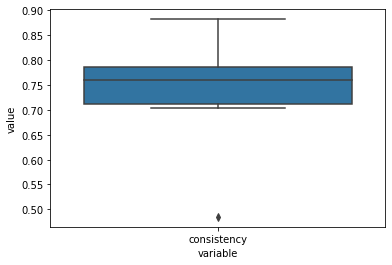

In [50]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'consistency':shap_xgbc_consistency})))

<AxesSubplot:xlabel='variable', ylabel='value'>

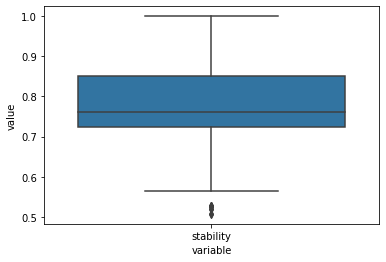

In [51]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'stability':shap_xgbc_stability})))

In [15]:
xgbc_perm = PermutationImportance(xgbc, random_state=1).fit(X_test, y_test)
xgbc_perm_importances = xgbc_perm.feature_importances_

show_weights(xgbc_perm, feature_names=FEATURE_IDS)

Weight,Feature
0.0846 ± 0.0150,0
0.0442 ± 0.0100,1
0.0247 ± 0.0102,3
0.0057 ± 0.0074,9
0.0041 ± 0.0040,4
0.0034 ± 0.0070,10
0.0027 ± 0.0045,2
0.0005 ± 0.0011,5
0.0003 ± 0.0025,8
-0.0002 ± 0.0005,7


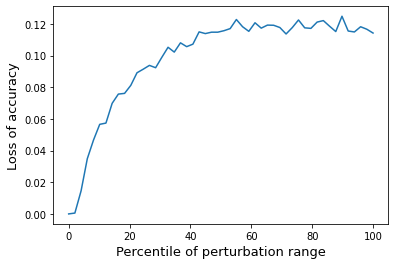

In [43]:
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=10),X_test.columns)])
shap_xgbc_acc_loss = gm.gradual_perturbation(model=xgbc, X=X_test, y=y_test, column_transformer=ct, importances_orig=xgbc_perm_importances, resolution=50,  count_per_step=10)

to_pickle(shap_xgbc_acc_loss, 'shap_xgbc_acc_loss')
# shap_xgbc_acc_loss = from_pickle('shap_xgbc_acc_loss')

In [29]:
approximateAreaUnderTheCurveAccLoss(shap_xgbc_acc_loss)

0.09833578792341674

## xgbc' SHAP's optimization

In [20]:
shap_xgbc[0:2]

[array([ 3.02014536e-01,  6.71224127e-02,  2.90870041e-02, -3.01963987e-02,
         5.11021756e-02,  4.85880732e-04,  9.06150352e-03,  1.76172695e-04,
         9.46885988e-04,  1.51681280e-02, -1.92430116e-02]),
 array([ 0.06850452,  0.0536528 , -0.00894848,  0.04073995,  0.00733186,
        -0.00029289,  0.02493507, -0.00027245, -0.00054055, -0.0121101 ,
         0.02580632])]

### TO-DO
- fix metrics used
- use tree models
- SMAC 